# DYNAMIC MODEL

## Introduction

### Additional Simplifications in the Dynamic Study

Below we present the **additional simplifications**, beyond those already applied in the steady-state study, that were introduced in our **dynamic model**. We considered these as minor additions that would not bring substantial pedagogical value and were relatively secondary within the scope of our analysis.

- We **assumed identical auxiliary heat gains** in the bathroom and in the living room.

- We **simplified the solar heat flux sources**, retaining only **three types**:
  - `φ_o`: solar radiation **absorbed by the external opaque walls**.
  - `φ_a`: radiation **absorbed by the glazing surfaces**.
  - `φ_i`: solar radiation **transmitted through the glazing and absorbed by the internal walls**.

To simplify the calculation of the glazing-related fluxes, we assumed a **total glazing surface** equal to the **sum of the bathroom and living room windows**. This resulted in the following changes in the code, compared to the steady-state model:

- `phi_0 = phi_19 = φ_o`
- `phi_10 = phi_14 = φ_a`
- `phi_4 = phi_6 = phi_8 = phi_15 = φ_i`

This simplification helped us avoid repetitive and unnecessary calculations. However, it also meant we had to assume **the same solar irradiance** for all window surfaces, despite their different orientations.

> To improve the accuracy of the results, it would have been better to calculate a specific `E_tot` for each façade based on its orientation, and then compute a weighted average according to the corresponding glazing surface areas.


## Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctrl
import time

import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf

In [2]:
controller = True
Kp = 1e3    # W/°C, controller gain

neglect_air_capacity = False
neglect_glass_capacity = False

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step 

## State-space representation

![Thermal model](thermal.png)

*Figure 1: Thermal mode*

In [3]:
# Thermal circuits
TC = dm4bem.file2TC('toy_model.csv', name='', auto_number=False)

# by default TC['G']['q1'] = 0 # Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q1'] = Kp      # G1 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ5'] = 0       # C5, capacity of vertex θ5 (air)
if neglect_glass_capacity:
    TC['C']['θ9'] = 0       # C9, capacity of vertex θ9 (glass) 

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7   θ8   θ9  θ10  θ11  θ12  θ13  \
q0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
q2   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q3  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q4   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q5   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q6   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q7   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q8   0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
q9   0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
q10  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0   
q11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0

The condition for numerical stability of Euler explicit integration

In [4]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

dt = 120 s = 2.0 min


## Input data set

In [5]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = 'FRA_AR_Lyon-Bron.AP.074800_TMYx.2004-2018.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date


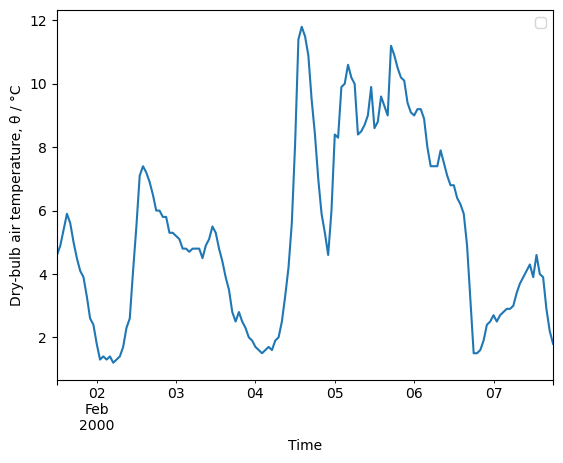

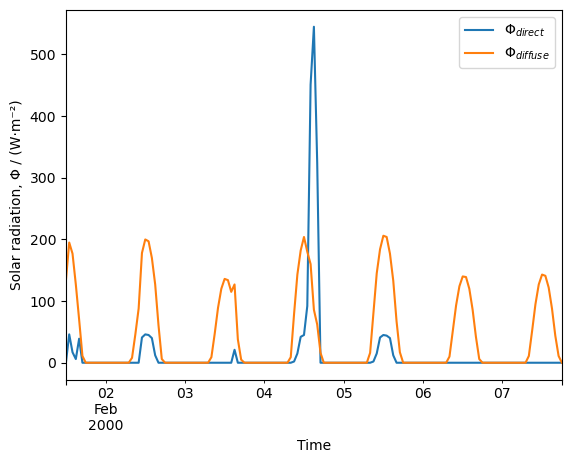

In [6]:
# Temperature sources
To = weather['temp_air']

To.plot()
plt.xlabel("Time")
plt.ylabel("Dry-bulb air temperature, θ / °C")
plt.legend([])
plt.show()

weather[['dir_n_rad', 'dif_h_rad']].plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation, Φ / (W·m⁻²)")
plt.legend(['$Φ_{direct}$', '$Φ_{diffuse}$'])
plt.show()

In [7]:
# total solar irradiance
wall_out = pd.read_csv('walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])
print(wall_out)

   ID  type  Area   β  γ  albedo  T0  Q0  Q1  h0  h1    α0   α1    ε0   ε1  \
0  w0     0    51  90  0    0.45  To  Φo  Φi  25   8  0.25  0.3  0.85  0.7   

      y  
0  [-1]  


In [8]:
print(f"{rad_surf.loc['2000-02-02 12:00']['direct']:.0f} W/m²")
print(f"Mean. direct irradiation: {rad_surf['direct'].mean():.0f} W/m²")
print(f"Max. direct irradiation:  {rad_surf['direct'].max():.0f} W/m²")
print(f"Direct solar irradiance is maximum on {rad_surf['direct'].idxmax()}")

40 W/m²
Mean. direct irradiation: 8 W/m²
Max. direct irradiation:  308 W/m²
Direct solar irradiance is maximum on 2000-02-04 14:00:00+01:00


The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [9]:
Etot = rad_surf.sum(axis=1)

### The short wave (i.e. solar) radiation, in W

#### Window glass properties

In [26]:
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
S_g  = 7*3      # Glazing surface

In [11]:
# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot

In [12]:
# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot

In [13]:
# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot

### Schedules
#### Indoor air temperature set-point

$$T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]$$

is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$. Let's consider the indoor temperature set-point different between day and night: $Ti_{day} = 20 \, \mathrm{°C}$; $Ti_{night} = 16 \, \mathrm{°C}$.

In [14]:
Ti_day, Ti_night = 20, 16

Tisp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

In [15]:
Qa = 120 

### Input data set

In [16]:
# Input data set
input_data_set = pd.DataFrame({'To': To, 'Tisp': Tisp,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa,  'Φa': Φa,
                               'Etot': Etot})

In [17]:
input_data_set.to_csv('input_data_set.csv')
input_data_set

,To,Tisp,Φo,Φi,Qa,Φa,Etot
2000-02-01 12:00:00+01:00,4.6,20,1933.155000,199.001250,120,1008.273000,126.350000
2000-02-01 13:00:00+01:00,4.9,20,3512.661828,361.597541,120,1832.094208,229.585740
2000-02-01 14:00:00+01:00,5.4,20,2782.969174,286.482121,120,1451.509412,181.893410
2000-02-01 15:00:00+01:00,5.9,20,1901.569813,195.749834,120,991.799158,124.285609
2000-02-01 16:00:00+01:00,5.6,20,1248.585456,128.530856,120,651.223003,81.606893
...,...,...,...,...,...,...,...
2000-02-07 14:00:00+01:00,4.0,20,1773.270000,182.542500,120,924.882000,115.900000
2000-02-07 15:00:00+01:00,3.9,20,1279.080000,131.670000,120,667.128000,83.600000
2000-02-07 16:00:00+01:00,2.9,20,639.540000,65.835000,120,333.564000,41.800000
2000-02-07 17:00:00+01:00,2.2,20,159.885000,16.458750,120,83.391000,10.450000


### Resample input data set

The weather data and the scheduled sources are at the time-step of 1 h. The data needs to be resampled at time step `dt` used for numerical integration.

In [18]:
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set.head()

,To,Tisp,Φo,Φi,Qa,Φa,Etot
2000-02-01 12:00:00+01:00,4.60,20.0,1933.155000,199.001250,120.0,1008.273000,126.350000
2000-02-01 12:02:00+01:00,4.61,20.0,1985.805228,204.421126,120.0,1035.733707,129.791191
2000-02-01 12:04:00+01:00,4.62,20.0,2038.455455,209.841003,120.0,1063.194414,133.232383
2000-02-01 12:06:00+01:00,4.63,20.0,2091.105683,215.260879,120.0,1090.655121,136.673574
2000-02-01 12:08:00+01:00,4.64,20.0,2143.755910,220.680755,120.0,1118.115828,140.114765


## Input vector in time

In the _input data set_ an input, e.g. $T_o$, appears only once. However, the _i nput vector_ may contain the same time series multiple time.

The input in time is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_i, \Phi_i, \dot{Q_a}, \Phi_a, \Phi_a, \Phi_i, \Phi_o \right ]^T$:

where the input data set is:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation absorbed by the outdoor surface of the wall, W;

$\Phi_i$: time series vector of short wave (i.e. solar) radiation absorbed by the indoor surfaces of the wall, W;

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation absorbed by the window glass, W.

The *input vector* `u` is obtained from the *input data set*, $T_o, T_{i,sp}, \Phi_o, \Phi_i, \dot Q_a, \Phi_a$, by using the order of the sources given in the state-space model, `us`: `q0` = $T_o$, `q2` = $T_o$,`q13` = $T_o$, `q20` = $T_o$, `q25` = $T_o$, `q26` = $T_o$, `q1` = $T_{i,sp}$, `θ0` = $\Phi_o$, `θ4` = $\Phi_i$, `θ5` = $\dot Q_a$, `θ6` = $\Phi_i$, `θ8` = $\Phi_i$, `θ9` = $\dot Q_a$, `θ10` = $\Phi_a$, `θ14` = $\Phi_a$, `θ15` = $\Phi_i$, and `θ19` = $\Phi_o$.

In [19]:
# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()

,q0,q1,q2,q13,q20,q25,θ0,θ4,θ5,θ6,θ8,θ9,θ10,θ14,θ15,θ19
2000-02-01 12:00:00+01:00,4.60,20.0,4.60,4.60,4.60,4.60,1933.155000,199.001250,120.0,199.001250,199.001250,120.0,1008.273000,1008.273000,199.001250,1933.155000
2000-02-01 12:02:00+01:00,4.61,20.0,4.61,4.61,4.61,4.61,1985.805228,204.421126,120.0,204.421126,204.421126,120.0,1035.733707,1035.733707,204.421126,1985.805228
2000-02-01 12:04:00+01:00,4.62,20.0,4.62,4.62,4.62,4.62,2038.455455,209.841003,120.0,209.841003,209.841003,120.0,1063.194414,1063.194414,209.841003,2038.455455
2000-02-01 12:06:00+01:00,4.63,20.0,4.63,4.63,4.63,4.63,2091.105683,215.260879,120.0,215.260879,215.260879,120.0,1090.655121,1090.655121,215.260879,2091.105683
2000-02-01 12:08:00+01:00,4.64,20.0,4.64,4.64,4.64,4.64,2143.755910,220.680755,120.0,220.680755,220.680755,120.0,1118.115828,1118.115828,220.680755,2143.755910


## Initial conditions

In [20]:
# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

## Time integration
The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

is integrated in time by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

or [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$


where $k = 0, ... , n - 1$.

In [21]:
I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

## Outputs

From the time variation of state variable $\theta_s$ we obtain the time variation of the output $y$ (i.e., indoor temperature):

$$y = C_s \theta_s + D_s u$$

In [22]:
# outputs
y = (Cs @ θ.T + Ds @  u.T).T

and the variation in time of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [23]:
Kp = TC['G']['q1']     # controller gain
S = 25                   # m², surface area of the living room
q_HVAC = Kp * (u['q1'] - y['θ9']) / S  # W/m²
y['θ9']

2000-02-01 12:00:00+01:00    20.000000
2000-02-01 12:02:00+01:00    19.788715
2000-02-01 12:04:00+01:00    19.856252
2000-02-01 12:06:00+01:00    19.742296
2000-02-01 12:08:00+01:00    19.754940
                               ...    
2000-02-07 17:52:00+01:00    18.128240
2000-02-07 17:54:00+01:00    18.124425
2000-02-07 17:56:00+01:00    18.120634
2000-02-07 17:58:00+01:00    18.116864
2000-02-07 18:00:00+01:00    18.113115
Freq: 120S, Name: θ9, Length: 4501, dtype: float64

## Plots

We select the data to plot:

- $T_o$, outdoor temperature, °C;
- $\theta_i$, indoor temperature, °C;
- $E_{tot}$, total solar irradiance, W/m²;
- $q_{HVAC}$, thermal load, i.e., the power that the HVAC system needs to deliver in order to maintain the indoor air temperature at its set-point, W.

In [24]:
data = pd.DataFrame({'To': input_data_set['To'],
                     'θlr': y['θ9'],
                     'θb': y['θ5'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

### Plots using Pandas

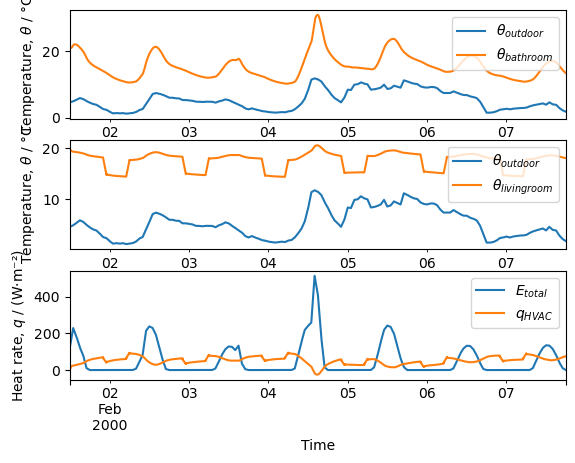

In [25]:
fig, axs = plt.subplots(3, 1)

data[['To', 'θb']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{bathroom}$'],
              loc='upper right')


data[['To', 'θlr']].plot(ax=axs[1],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[1].legend(['$θ_{outdoor}$', '$θ_{living room}$'],
              loc='upper right')


data[['Etot', 'q_HVAC']].plot(ax=axs[2],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[2].set(xlabel='Time')
axs[2].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();

> Simulation in free-running with weather data using Euler explicit method of integration. a) Bathroom and outdoor temperatures. b) Living room and outdoor temperatures.c) Solar and HVAC heat flow rates.